In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import re
import hashlib
import time
import datetime as dt
from pandas.tseries.offsets import BDay
from matplotlib.lines import Line2D
import multiprocessing as mp
import calendar
from dateutil.relativedelta import relativedelta
# Makes the quality of display plot better: retina quality
%config InlineBackend.figure_format = 'retina'

# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None

source_dir = "data/"

#if not os.path.isdir(source_dir):
#    os.mkdir(dest_dir)
    
#db = {}
#for f in os.listdir(source_dir):
#    if ".csv" in f:
#        db[os.path.splitext(f)[0]] = pd.read_csv(source_dir + f, low_memory=False)    

# Print the tables in each csv        
#        for k, df in db.items():
#            print ("Table/dataframe: %s (Length: %d)" %(k, len(df)))
#            #print (("\t"  +  "\n\t").join(sorted(df.columns.tolist())), "\n")
#            print (("\t"),("\n" "\t ").join(sorted(df.columns.tolist())), "\n")
    
%run graphics.ipynb
nodes_df=pd.read_csv(source_dir + "nodes.csv")

In [2]:
node_inception = nodes_df[['type', 'inception']] 
# aggregate by the first date found per hardware
node_inception = node_inception.groupby('type').agg(min)
# Remove rows with Null values in inception time. It does not affect the node_count.


node_inception.head(10)


,inception
type,
APC,NaN
C240M4,2015-03-02 23:24:49
RPC27,None
Raritan,None
apcon,None
arista7500,None
bbg,2013-03-11 21:45:19
bbgeni,NaN
blockstore,2016-03-01 16:14:34


In [3]:
node_inception.shape

(106, 1)

## Table with each node type and its starting time. 

In [4]:
node_inception = node_inception.dropna()
node_inception.head()

,inception
type,
C240M4,2015-03-02 23:24:49
bbg,2013-03-11 21:45:19
blockstore,2016-03-01 16:14:34
c220g1,2016-04-15 13:20:23
c220g2,2016-03-11 02:34:39


In [5]:
node_count = nodes_df["type"].value_counts()
node_count.head(10)



pcvm      344
m400      315
m510      270
c220g5    224
xl170     200
c220g2    163
d710      161
d430      160
pc3000    157
r320      128
Name: type, dtype: int64

In [6]:
type(node_count)

pandas.core.series.Series

## Table with Nodes, their quantity and when did were they deployed in cloudlab

In [7]:
node_inception_qty = node_inception.merge(node_count.to_frame(), left_index=True, right_index=True)
node_inception_qty.rename(columns={'type':'qty'}, inplace=True)
node_inception_qty.T

,C240M4,bbg,blockstore,c220g1,c220g2,c220g5,c240g1,c240g2,c240g5,c4130,...,pcdp,pcivy,pcpg-i2,pcvm,r320,r720,sdr,spp,x310,xl170
inception,2015-03-02 23:24:49,2013-03-11 21:45:19,2016-03-01 16:14:34,2016-04-15 13:20:23,2016-03-11 02:34:39,2018-02-17 22:33:33,2016-05-25 14:47:18,2016-05-26 12:14:14,2018-02-06 00:40:00,2016-03-24 14:57:07,...,2007-11-28 12:42:44,2013-02-01 16:19:35,2009-08-05 00:12:05,2016-02-19 14:10:13,2014-05-24 20:30:48,2014-09-25 12:26:55,2017-08-29 11:55:02,2009-12-08 10:59:36,2019-03-26 13:29:46,2018-01-25 19:19:30
qty,1,1,31,90,163,224,6,4,32,6,...,2,1,11,344,128,2,2,3,3,200


In [8]:
#Saving it as a csv. Will have null values for some rows in the inception column
node_inception_qty.to_csv('sahil_data/node_inception_with_qty.csv')

In [9]:
# Earliest date of inception
node_inception_qty.isnull().sum()


inception    0
qty          0
dtype: int64

In [10]:
node_inception_qty['inception'].describe()

count                      69
unique                     69
top       2007-06-20 07:16:14
freq                        1
Name: inception, dtype: object

In [11]:
node_inception_qty['date_time'] = node_inception_qty['inception'].astype('datetime64[ns]')

In [12]:
# Find the range of time since the first node was installed until the latest inception. 
print( 
    "Time interval: "+ 
      str(node_inception_qty.date_time.min()) + " to " + 
    str(node_inception_qty.date_time.max())
)

Time interval: 2005-08-03 10:10:39 to 2019-03-29 08:52:59


In [13]:
# Replace all null values with the earliest time stamp.

inception = node_inception_qty['date_time']
inception_oldest = inception.min() # fetch the oldest timestamp
inception.fillna(inception_oldest, inplace=True)
#inception.isnull().sum() # should be zero


In [14]:
node_inception_qty = node_inception_qty.drop(['inception'], axis=1) # dropping duplicate column


In [26]:
node_inception_qty = node_inception_qty.sort_values(by=['date_time']) # sorting by timestamp
node_inception_qty['cum_qty'] = node_inception_qty['qty'].cumsum()
#Saving it as a csv
node_inception_qty.to_csv('sahil_data/node_inception_with_qty.csv')


In [27]:
node_inception_qty

,qty,date_time,cum_qty
pc3000,157,2005-08-03 10:10:39,157
pc1500,2,2007-06-20 07:16:10,159
pc850,3,2007-06-20 07:16:14,162
pcdp,2,2007-11-28 12:42:44,164
pc2400w,16,2007-12-19 09:49:34,180
...,...,...,...
dellrest-s5248,5,2019-02-23 08:41:23,2821
d840,3,2019-02-23 08:50:20,2824
faros_sfp,1,2019-03-20 14:40:57,2825
x310,3,2019-03-26 13:29:46,2828


<AxesSubplot:xlabel='date_time'>

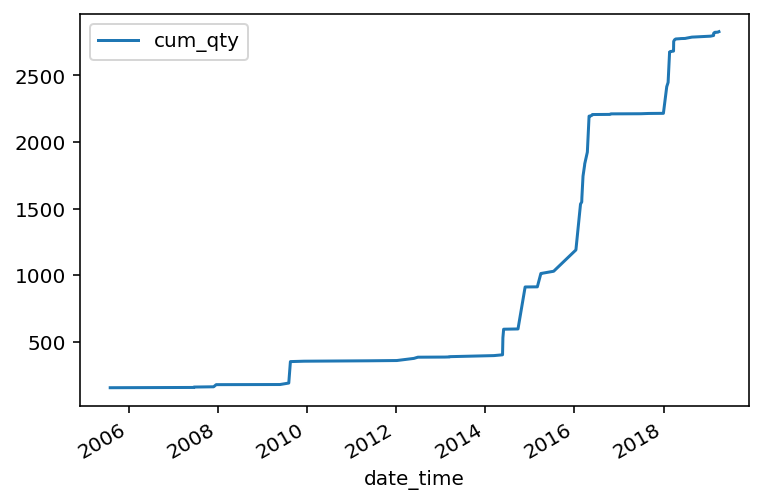

In [28]:
node_inception_qty.plot(x = 'date_time', y = 'cum_qty', kind = 'line')

,qty,date_time,cum_qty
pc3000,157,2005-08-03 10:10:39,157
pc1500,2,2007-06-20 07:16:10,159
pc850,3,2007-06-20 07:16:14,162
pcdp,2,2007-11-28 12:42:44,164
pc2400w,16,2007-12-19 09:49:34,180
...,...,...,...
dellrest-s5248,5,2019-02-23 08:41:23,2821
d840,3,2019-02-23 08:50:20,2824
faros_sfp,1,2019-03-20 14:40:57,2825
x310,3,2019-03-26 13:29:46,2828
